In [1]:
import os

from PIL import Image
from transformers import (
    AutoModelForDepthEstimation,
    AutoImageProcessor,
)

# from torch.utils.tensorboard import SummaryWriter
import cv2
import numpy as np
import torch
import torch.nn.functional as F

from data_processing import simcol, c3vd, combined

# from training import training_utils
# from eval import evaluation
# from utils import utils
import lightning_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/grad/masters/2025/avaishna/miniconda3/envs/new_endoenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


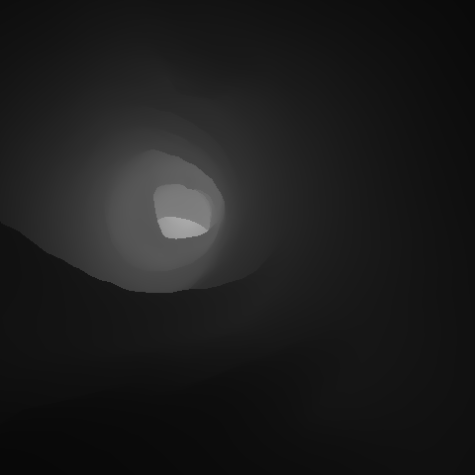

In [3]:
image = Image.open("./datasets/SyntheticColon_I/Frames_S1/Depth_0000.png")
image

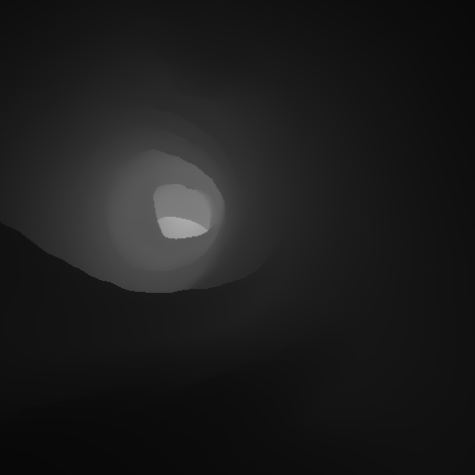

In [4]:
bgr_img = cv2.imread("./datasets/SyntheticColon_I/Frames_S1/Depth_0000.png")
img_rgb = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
Image.fromarray(img_rgb)
# cv2.applyColorMap(img_rgb, cv2.COLORMAP_INFERNO)[:, :, ::-1]

In [ ]:
processor = AutoImageProcessor.from_pretrained(
    "depth-anything/Depth-Anything-V2-Base-hf"
)
model = AutoModelForDepthEstimation.from_pretrained(
    "depth-anything/Depth-Anything-V2-Base-hf"
)
model.to(device)
print("Model device:", model.device)

Model device: cuda:0


In [9]:
pixel_values = processor(
    images=img_rgb,
    return_tensors="pt",
).pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 518, 518])


In [ ]:
with torch.no_grad():
    pixel_values = pixel_values.to(device)
    outputs = model(pixel_values)
    predicted_depth = outputs.predicted_depth

# print('Outputs device:', outputs.device)
print("Predicted depth device:", predicted_depth.device)

Predicted depth device: cuda:0


In [ ]:
h, w = pixel_values.shape[-2:]

depth = torch.nn.functional.interpolate(
    predicted_depth[None], (h, w), mode="bilinear", align_corners=True
)[0, 0]

print("Depth device:", depth.device)

Depth device: cuda:0


In [ ]:
print(depth)

tensor([[225.3000, 225.1813, 225.3848,  ..., 295.7285, 295.8804, 261.8903],
        [223.1445, 224.6423, 225.2478,  ..., 295.7877, 293.6039, 295.0207],
        [224.3411, 224.6601, 224.2846,  ..., 290.7819, 294.3518, 296.2954],
        ...,
        [449.5935, 451.2423, 451.4223,  ..., 427.1665, 428.5779, 428.5594],
        [452.3710, 451.5480, 452.9283,  ..., 429.2762, 429.7755, 429.5216],
        [451.5570, 451.9554, 452.5388,  ..., 428.5278, 429.7835, 429.9498]])


In [ ]:
print(pixel_values[0, 0])

tensor([[-1.8782, -1.8782, -1.8782,  ..., -1.9467, -1.9467, -1.9467],
        [-1.8782, -1.8782, -1.8782,  ..., -1.9467, -1.9467, -1.9467],
        [-1.8782, -1.8782, -1.8782,  ..., -1.9467, -1.9467, -1.9467],
        ...,
        [-1.9809, -1.9809, -1.9809,  ..., -1.8610, -1.8610, -1.8610],
        [-1.9809, -1.9809, -1.9809,  ..., -1.8610, -1.8610, -1.8610],
        [-1.9809, -1.9809, -1.9809,  ..., -1.8610, -1.8610, -1.8610]])


In [ ]:
raw_depth = Image.fromarray(depth.cpu().numpy().astype("uint16"))
raw_depth.save("predicted_depth.png")

raw_depth_8 = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
raw_depth_8 = raw_depth_8.cpu().numpy().astype(np.uint8)

# Apply the Spectral_r colormap to the depth map
colored_depth = cv2.applyColorMap(raw_depth_8, cv2.COLORMAP_JET)[:, :, ::-1]

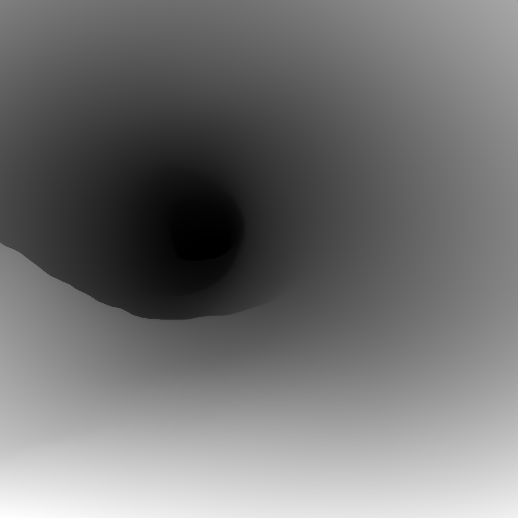

In [ ]:
Image.fromarray(raw_depth_8)

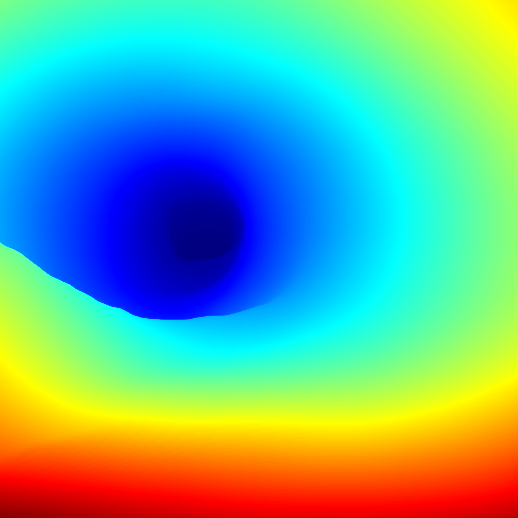

In [ ]:
Image.fromarray(colored_depth)

In [ ]:
def eval_depth(pred, gt_depth):
    # * 20 to get centimeters
    diff = (pred - gt_depth) * 20

    epsilon = 1e-6  # Small positive constant
    L1_error = np.mean(np.abs(diff))
    abs_rel = np.mean(np.abs(diff) / (gt_depth * 20 + epsilon))
    rel_error = (
        np.median(
            np.abs((diff) / (gt_depth * 20 + epsilon)),
        )
        * 100
    )
    RMSE_error = np.sqrt(np.mean((diff) ** 2))
    return L1_error, abs_rel, rel_error, RMSE_error


l1, abs, rel, rmse = eval_depth(
    depth.cpu().numpy().astype("uint16"),
    pixel_values[0, 0].cpu().numpy().astype("uint16"),
)
print(f"L1 error: {l1}")
print(f"Abs Rel error: {abs}")
print(f"Rel error: {rel}")
print(f"RMSE error: {rmse}")

L1 error: 4151.948539824988
Abs Rel error: 42581580.54005647
Rel error: 6.593809145756856
RMSE error: 173.90286760502207


In [2]:
input_path = "./datasets/"
train_vids = [os.path.join(input_path, "SyntheticColon_II/Frames_B14")]
test_vids = [os.path.join(input_path, "SyntheticColon_II/Frames_B5")]

train_depth = []
train_rgb = []
test_depth = []
test_rgb = []

#  Load training frames
for vid in train_vids:
    depth, rgb = utils.load_frames(vid)
    train_depth.extend(depth)
    train_rgb.extend(rgb)

for vid in test_vids:
    depth, rgb = utils.load_frames(vid)
    test_depth.extend(depth)
    test_rgb.extend(rgb)

In [3]:
train_dataloader, val_dataloader = dataloader.get_dataloaders(
    train_depth, train_rgb, test_depth, test_rgb, batch_size=32
)

# Load only the first batch
train_batch = next(iter(train_dataloader))

In [4]:
# RGB image and depth map range of values
print(train_batch[0].min(), train_batch[0].max())  # RGB
print(train_batch[1].min(), train_batch[1].max())  # Depth

tensor(-1.5604) tensor(2.4286)
tensor(0.5306) tensor(12.8129)


In [13]:
print(train_batch[0].shape)  # RGB
print(train_batch[1].shape)  # Depth

print(train_batch[0].shape[-2:])

torch.Size([32, 3, 350, 350])
torch.Size([32, 350, 350])
torch.Size([350, 350])


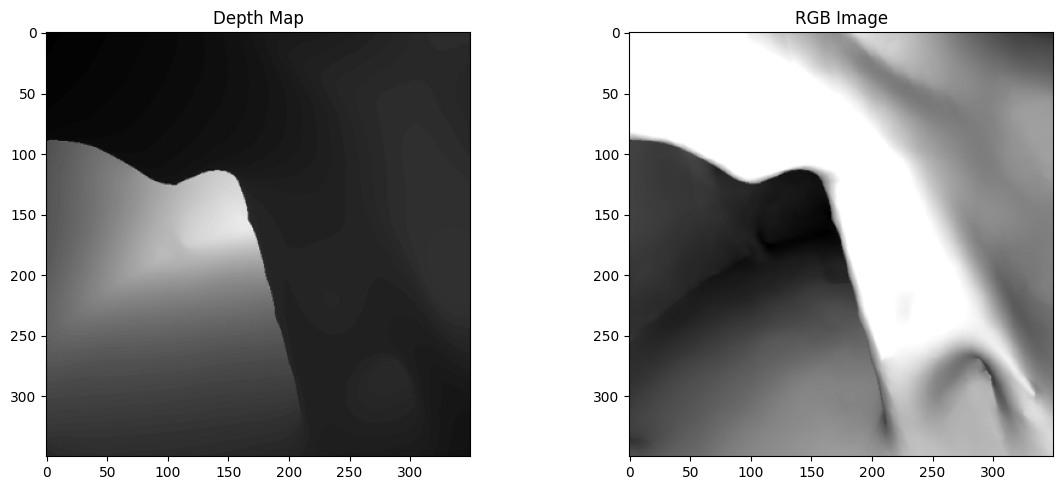

In [6]:
import matplotlib.pyplot as plt

# Display the first image and depth map in the batch
# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Plot RGB image
plt.subplot(1, 2, 1)
plt.imshow(train_batch[1][0], cmap="gray")  # RGB image
plt.title("Depth Map")

# Plot depth map
plt.subplot(1, 2, 2)
plt.imshow(train_batch[0][0][0], cmap="gray")  # Depth map
plt.title("RGB Image")

plt.tight_layout()
plt.show()

In [7]:
size = "Small"

model = training_utils.DepthEstimationModule(
    model_name=f"depth-anything/Depth-Anything-V2-{size}-hf",
    device=device,
)

In [8]:
use_scheduler = True
warmup_steps = 500
logdir = "./logs/testing_nb"

# Set up TensorBoard writer
writer = SummaryWriter(
    log_dir=os.path.join(
        logdir,
        "custom",
    ),
)

# Set up optimizer and scheduler
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
)

scheduler = (
    training_utils.WarmupReduceLROnPlateau(
        optimizer,
        warmup_steps=warmup_steps,
        factor=0.5,
        patience=5,
    )
    if use_scheduler
    else None
)

# Initialize EarlyStopping
early_stopping = training_utils.EarlyStopping(
    patience=5,
    verbose=True,
    # path=os.path.join(output_path, f"{custom_model_name}_checkpoint.pt"),
)

In [9]:
epochs = 1
for epoch in range(epochs):
    train_loss = training_utils.train(
        model,
        train_dataloader,
        epoch,
        optimizer,
        device,
        writer,
    )

    val_loss = training_utils.validate(
        model,
        val_dataloader,
        epoch,
        device,
        writer,
    )

    print(
        "Epoch %d/%d, Train Loss: %.4f",
        epoch + 1,
        epochs,
        train_loss,
    )
    print(
        "Epoch %d/%d, Val Loss: %.4f",
        epoch + 1,
        epochs,
        val_loss,
    )

    # If using a scheduler, step it
    if scheduler:
        if isinstance(
            scheduler,
            training_utils.WarmupReduceLROnPlateau,
        ):
            scheduler.step(val_loss)
        else:
            scheduler.step()

    current_lr = optimizer.param_groups[0]["lr"]
    print(f"Current Learning Rate: {current_lr:.6f}")
    writer.add_scalar("Train/LearningRate", current_lr, epoch)

    # Early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

Training Epoch 1:   0%|          | 0/37 [00:00<?, ?it/s]

2024-11-02 18:07:27,840 - INFO - Trainable parameters: 287, Frozen parameters: 0
2024-11-02 18:07:29,552 - INFO - Outputs range: 0.053 to 9.296
2024-11-02 18:07:29,554 - INFO - Targets range: 0.419 to 12.290
2024-11-02 18:07:29,669 - INFO - Loss value: 9.538347244262695
2024-11-02 18:07:29,671 - WARNING - Zero gradients detected in 287/287 parameters (100.0%)
Training Epoch 1:   3%|▎         | 1/37 [00:03<02:14,  3.74s/it, loss=9.54]2024-11-02 18:07:30,563 - INFO - Trainable parameters: 287, Frozen parameters: 0
2024-11-02 18:07:31,421 - INFO - Outputs range: 0.183 to 8.008
2024-11-02 18:07:31,423 - INFO - Targets range: 0.531 to 11.078
2024-11-02 18:07:31,426 - INFO - Loss value: 10.103405952453613
2024-11-02 18:07:31,428 - WARNING - Zero gradients detected in 287/287 parameters (100.0%)
Training Epoch 1:   5%|▌         | 2/37 [00:04<01:14,  2.14s/it, loss=10.1]2024-11-02 18:07:31,580 - INFO - Trainable parameters: 287, Frozen parameters: 0
2024-11-02 18:07:32,386 - INFO - Outputs ran

Epoch %d/%d, Train Loss: %.4f 1 1 3.175352472711254
Epoch %d/%d, Val Loss: %.4f 1 1 0.3822105485749872
Current Learning Rate: 0.000000


In [10]:
def eval_depth(pred, gt_depth):
    # * 20 to get centimeters
    diff = (pred - gt_depth) * 20

    epsilon = 1e-6  # Small positive constant
    L1_error = np.mean(np.abs(diff))
    abs_rel = np.mean(np.abs(diff) / (gt_depth * 20 + epsilon))
    rel_error = (
        np.median(
            np.abs((diff) / (gt_depth * 20 + epsilon)),
        )
        * 100
    )
    RMSE_error = np.sqrt(np.mean((diff) ** 2))
    return L1_error, abs_rel, rel_error, RMSE_error

In [11]:
import glob
from tqdm import tqdm

test_vids = [os.path.join(input_path, "SyntheticColon_II/Frames_B15/*.png")]

test_rgb = []
test_depth = []

#  Load training frames
for vid in test_vids:
    files = sorted(glob.glob(vid))
    test_rgb += [f for f in files if f.split("/")[-1].startswith("Frame")]
    test_depth += [f for f in files if f.split("/")[-1].startswith("Depth")]

test_dataloader = dataloader.get_dataloaders_test(test_rgb)

model = AutoModelForDepthEstimation.from_pretrained(
    "finetuning/pretrained_l0.0005_e12_b64_mLarge_s1_w1000"
)
processor = AutoImageProcessor.from_pretrained(
    "depth-anything/Depth-Anything-V2-Base-hf"
)
model.to(device)
print("Model device:", model.device)

model.eval()

# Generate predictions for the test set and use the eval_depth function to calculate the metrics
l1_errors = []
abs_rel_errors = []
rel_errors = []
rmse_errors = []

with tqdm(test_dataloader, desc=f"Testing") as pbar:
    for i, batch in enumerate(pbar):
        with torch.no_grad():
            batch = (batch - batch.min()) / (batch.max() - batch.min())
            pixel_values = processor(
                images=batch,
                return_tensors="pt",
                do_rescale=False,
            ).pixel_values.to(device)
            outputs = model(pixel_values)
            predicted_depth = outputs.predicted_depth

            for j in range(len(batch)):
                l1, abs_rel, rel, rmse = eval_depth(
                    predicted_depth[j].cpu().numpy().astype("uint16"),
                    pixel_values[j, 0].cpu().numpy().astype("uint16"),
                )
                l1_errors.append(l1)
                abs_rel_errors.append(abs_rel)
                rel_errors.append(rel)
                rmse_errors.append(rmse)

print(f"L1 error: {np.mean(l1_errors)}")
print(f"Abs Rel error: {np.mean(abs_rel_errors)}")
print(f"Rel error: {np.mean(rel_errors)}")
print(f"RMSE error: {np.mean(rmse_errors)}")

Model device: cuda:0


Testing:  12%|█▏        | 142/1201 [00:12<01:29, 11.83it/s]


KeyboardInterrupt: 

In [2]:
# Load the c3vd dataset
input_path = "./datasets/"
train_dataset = c3vd.C3VD_Dataset(
    data_dir="./datasets/C3VD/",
    data_list="./datasets/C3VD/train.txt",
    mode="Train",
    size=518,
    hflip=True,
    vflip=True,
    ds_type="c3vd",
)

In [3]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
)

# Load only the first batch
train_batch = next(iter(train_dataloader))

# RGB image and depth map range of values
print(train_batch["image"].min(), train_batch["image"].max())  # RGB
print(train_batch["depth"].min(), train_batch["depth"].max())  # Depth

tensor(-2.1179) tensor(2.6400)
tensor(0.) tensor(100.0000)


In [6]:
# Print how many batches are in the dataloader
print(len(train_dataloader))

476


In [5]:
# Check the depth range for all the batches and print if there are any outliers ~in [0, 100]
depths = []
for batch in train_dataloader:
    depths.append(batch["depth"].numpy())

depths = np.concatenate(depths)
print("Depth range:", depths.min(), depths.max())

Depth range: 0.0 100.00002


In [ ]:
for i, batch in enumerate(train_dataloader):
    if batch["depth"].min() < 0 or batch["depth"].max() > 100:
        print(f"Batch {i} has outliers")
        print(batch["depth"].min(), batch["depth"].max())

In [4]:
scaled_depth_values = []
for batch in train_dataloader:
    depth = batch["depth"] / 100.0  # Scale to [0, 1]
    scaled_depth_values.append(depth)

scaled_depth_tensor = torch.cat(scaled_depth_values)
mean = scaled_depth_tensor.mean().item()
std = scaled_depth_tensor.std().item()

print(f"Depth Mean (scaled): {mean}, Depth Std (scaled): {std}")

Depth Mean (scaled): 0.2802938222885132, Depth Std (scaled): 0.20831811428070068


In [4]:
import cv2


def check_image_size(image_path):
    img = cv2.imread(image_path)
    height, width = img.shape[:2]
    return width, height  # Should be 1350, 1080


# Check one image from each sequence
t1_size = check_image_size("./datasets/C3VD/trans_t1_a/0000_color.png")
t2_size = check_image_size("./datasets/C3VD/trans_t2_a/0000_color.png")
c1_size = check_image_size("./datasets/C3VD/cecum_t1_a/0_color.png")

print(t1_size)
print(t2_size)
print(c1_size)
# etc...

(1350, 1080)
(1350, 1080)
(1350, 1080)


In [21]:
import os
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

path = "./datasets/SyntheticColon/SyntheticColon_I/Frames_S1/Depth_0000.png"

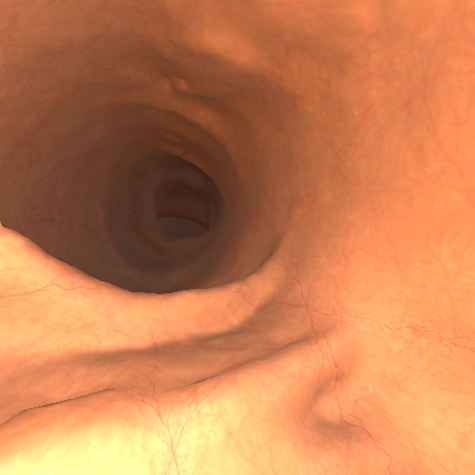

In [42]:
rgb = Image.open(
    "./datasets/SyntheticColon/SyntheticColon_I/Frames_S1/FrameBuffer_0000.png"
)
depth = Image.open(path)
rgb

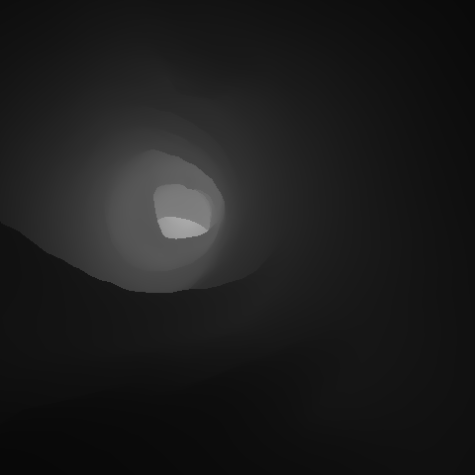

In [43]:
depth

Original depth range: 2048 to 43520


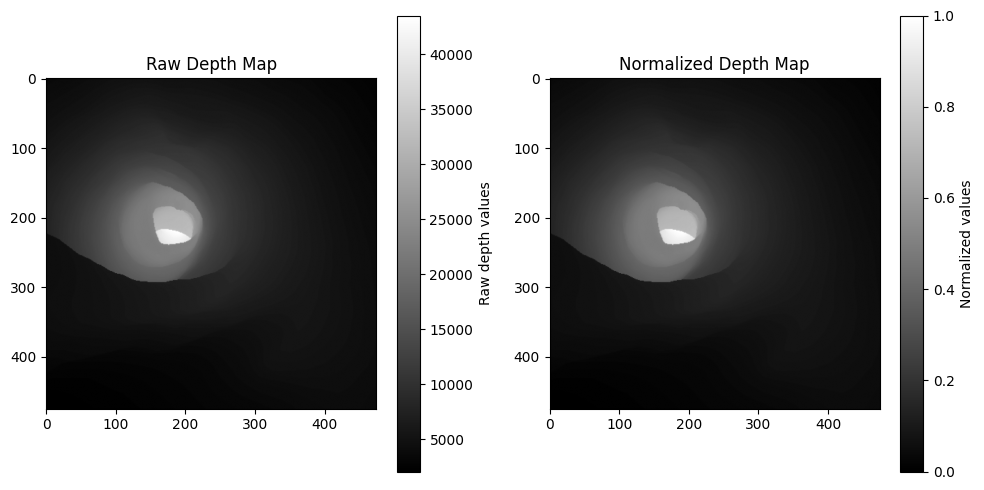

In [36]:
# Load and normalize the depth image
depth_img = np.array(Image.open(path))
print(f"Original depth range: {depth_img.min()} to {depth_img.max()}")

# Normalize to [0, 1] range
normalized_depth = (depth_img - depth_img.min()) / (depth_img.max() - depth_img.min())

# Create visualization
plt.figure(figsize=(10, 5))

# Original depth map
plt.subplot(121)
plt.imshow(depth_img, cmap="gray")
plt.colorbar(label="Raw depth values")
plt.title("Raw Depth Map")

# Normalized depth map
plt.subplot(122)
plt.imshow(normalized_depth, cmap="gray")
plt.colorbar(label="Normalized values")
plt.title("Normalized Depth Map")

plt.tight_layout()
plt.show()

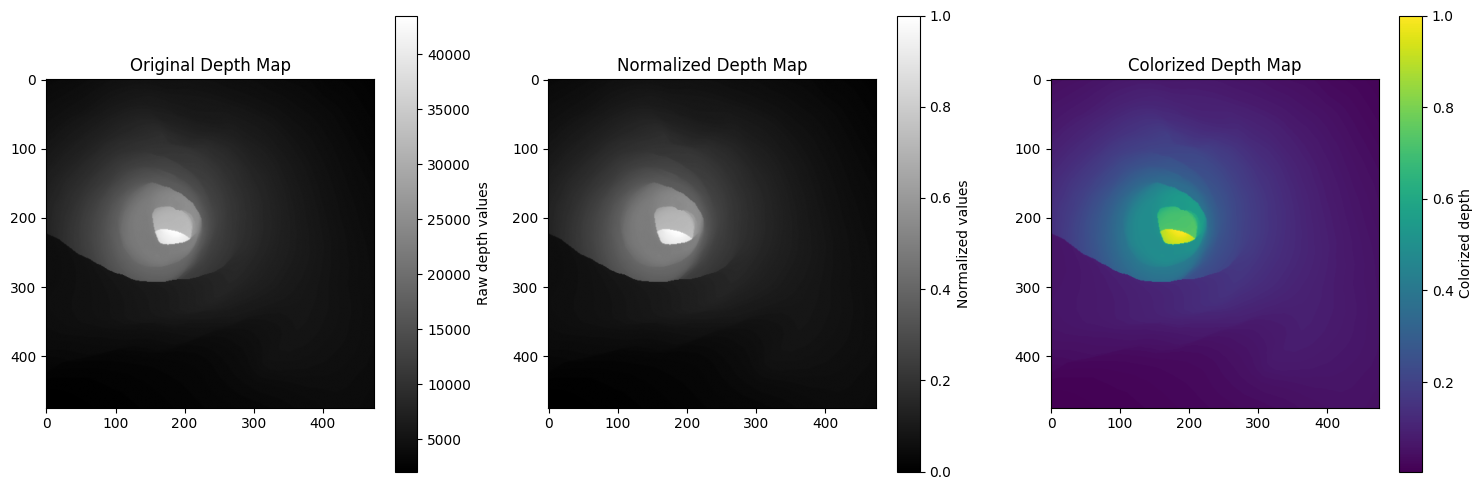

Original depth range: 2048 to 43520
Normalized range: 0.000 to 1.000


In [39]:
# Load and process images
depth_img = np.array(Image.open(path))
normalized_depth = (depth_img - depth_img.min()) / (depth_img.max() - depth_img.min())
# rgb_img = Image.open(path).convert("RGB")
rgb_img = np.stack([normalized_depth] * 3, axis=-1)
colored_depth = plt.cm.viridis(normalized_depth)

# Create visualization with three subplots
plt.figure(figsize=(15, 5))

# Original depth map
plt.subplot(131)
plt.imshow(depth_img, cmap="gray")
plt.colorbar(label="Raw depth values")
plt.title("Original Depth Map")

# Normalized depth map
plt.subplot(132)
plt.imshow(normalized_depth, cmap="gray")
plt.colorbar(label="Normalized values")
plt.title("Normalized Depth Map")

# RGB conversion
plt.subplot(133)
plt.imshow(colored_depth)
plt.colorbar(label="Colorized depth")
plt.title("Colorized Depth Map")

plt.tight_layout()
plt.show()

# Print value ranges for debugging
print(f"Original depth range: {depth_img.min()} to {depth_img.max()}")
print(f"Normalized range: {normalized_depth.min():.3f} to {normalized_depth.max():.3f}")

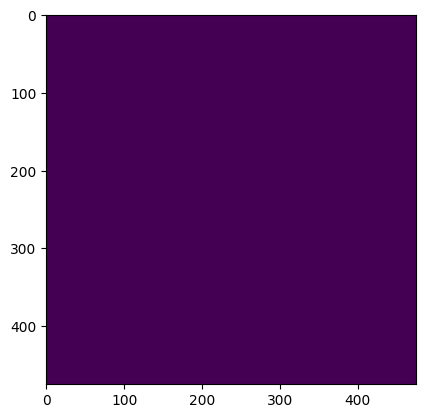

In [32]:
# pil_img_bgr = np.array(Image.open(path)) # BGR
# pil_img_bgr
pil_img_bgr = np.array(Image.open(path).convert("L")).astype(np.float32) / 255 / 256
# Image.fromarray(pil_img_bgr)
plt.imshow(pil_img_bgr)
# pil_img_rgb = pil_img_bgr.convert("RGB") # RGB
# pil_img_rgb
# cv_img_bgr = cv2.imread(path) # BGR
# cv_img_rgb = cv2.cvtColor(cv_img_bgr, cv2.COLOR_BGR2RGB) # RGB

In [18]:
print(pil_img_rgb.getpixel((0, 0)))  # (255, 255, 255)
print(pil_img_bgr.getpixel((0, 0)))  # 255

(255, 255, 255)
3584


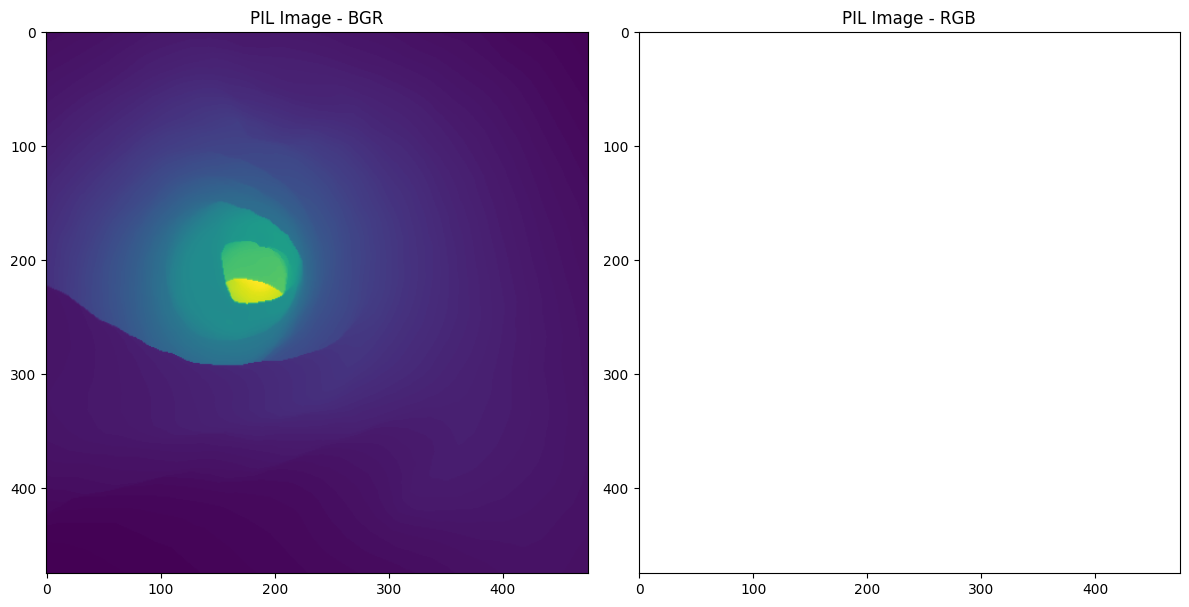

In [4]:
# Create a subaxis plot (ax1, ax2) where i can plot the images - pil_img_bgr and cv_img_bgr
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the PIL image
ax1.imshow(Image.open(path))
ax1.set_title("PIL Image - BGR")

# Plot the OpenCV image
# ax2.imshow(Image.fromarray(cv_img_bgr))
ax2.imshow(Image.open(path).convert("RGB"))
ax2.set_title("PIL Image - RGB")

plt.tight_layout()
plt.show()

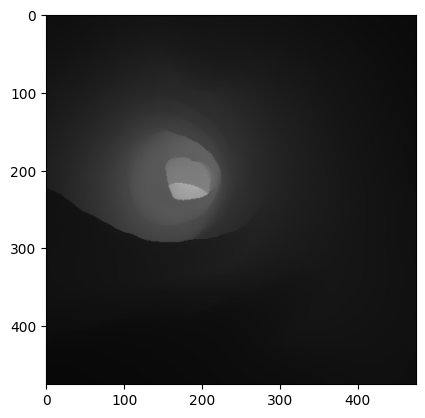

In [4]:
# Image.fromarray(cv_img_rgb)
plt.imshow(cv_img_rgb)